In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import statsmodels.api as sm

from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,IsolationForest,StackingClassifier
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def select_part_type(part_type):
    
    supervised_cn7 = pd.read_csv('supervised_label_cn7.csv').drop(['Unnamed: 0'],axis=1)
    
    data = pd.read_csv('labeled_data.csv').sort_values(by='TimeStamp')
    data = data.drop_duplicates(subset=['_id']).reset_index(drop=True)
    data = data[data['EQUIP_CD'] == 'S14'].reset_index(drop=True)
    data['PassOrFail'] = data['PassOrFail'].replace({'Y':0,'N':1})

    data['PART_FACT_SERIAL'] = data['PART_FACT_SERIAL'].astype(object)
    data['PassOrFail'] = data['PassOrFail'].astype(float)
    data['PART_TYPE'] = data['PART_NAME'].str.split(' ').str[0]

    data_object = data.select_dtypes(exclude='float64')
    data_numeric = data[supervised_cn7.columns.tolist()]

    df_final = pd.concat([data_object,data_numeric],axis=1)

    df_final = df_final.dropna(axis=1)

    df_final = df_final[df_final['PART_TYPE'] == part_type].reset_index(drop=True)
    
    print(part_type,'shape',df_final.shape)
    print('unique _ids :',df_final['_id'].nunique())
    print('\n')
    print(df_final['PART_TYPE'].value_counts())
    print('\n')
    print(df_final['PART_NAME'].value_counts())
    print('\n')
    print(df_final['EQUIP_CD'].value_counts())
    print('\n')
    print(df_final['EQUIP_NAME'].value_counts())
    print('\n')
    print('Normal & Fault Value Counts')
    print(df_final['PassOrFail'].value_counts())
    
    return df_final


def select_part_name(i):
    
    df_final = df_part_type[df_part_type['PART_NAME'] == part_names[i]]
    df_final = df_final.sort_values(by='TimeStamp').reset_index(drop=True)
    
    print(df_final['PART_TYPE'].value_counts())
    print('\n')
    print(df_final['PART_NAME'].value_counts())
    print('\n')
    print(df_final['PassOrFail'].value_counts())
    
    return df_final

def load_unlabeled_df(part_type):
    
    unlabeled = pd.read_csv('unlabeled_data.csv').drop(['Unnamed: 0'],axis=1)
    unlabeled['PART_TYPE'] = unlabeled['PART_NAME'].str.split(' ').str[0]

    unlabeled = unlabeled[(unlabeled['PART_TYPE'] == part_type) & (unlabeled['EQUIP_CD'] == 'S14')].reset_index(drop=True)
    unlabeled = unlabeled.drop_duplicates(subset=['_id']).reset_index(drop=True)

    print('part type:',unlabeled['PART_TYPE'].unique()[0],'shape',unlabeled.shape)
    print('unique _ids :',unlabeled['_id'].nunique())
    print('\n')
    print(unlabeled['PART_NAME'].value_counts())
    print('\n')
    print(unlabeled['EQUIP_CD'].value_counts())
    print('\n')
    print(unlabeled['EQUIP_NAME'].value_counts())
    
    return unlabeled

def unlabeled_part_name(i):
    
    df_unlabeled = unlabeled[unlabeled['PART_NAME'] == part_names[i]]
    df_final = df_unlabeled.sort_values(by='TimeStamp').reset_index(drop=True)
    
    print(df_final['PART_TYPE'].value_counts())
    print('\n')
    print(df_final['PART_NAME'].value_counts())
    
    return df_final

In [3]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss,bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

def anomaly_threshold(threshold,model):
    test_score_df = pd.DataFrame(x_test[:])
    test_score_df['loss'] = test_mae_loss 
    test_score_df['threshold'] = threshold 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['PassOrFail']})

    plt.figure(figsize=(8, 6))
    plt.title('AutoEncoder Reconstruction Error', fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal',color='blue',marker='+')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault',color='red',marker='+')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()
    

def pred_anomaly_threshold(threshold):
    
    pred_score_df = pd.DataFrame(x_pred[:])
    pred_score_df['mae_loss'] = pred_mae_loss # --> pred_proba
    pred_score_df['threshold'] = threshold # 레이블 예측 임계값 
    pred_score_df['anomaly'] = pred_score_df['mae_loss'] > pred_score_df['threshold']
    pred_score_df['score'] = pred_score_df["anomaly"].astype(int) # 예측 레이블 
    print(pred_score_df['score'].value_counts())
    pred_check = pd.concat([x_pred.reset_index(drop=True),pred_score_df['mae_loss'],pred_score_df['threshold'],pred_score_df['anomaly'],pred_score_df['score']],axis=1)

    pred_error = pd.DataFrame({'Reconstruction_error': pred_score_df['mae_loss'],'Anomaly': pred_score_df['score']})

    pred_df = pd.concat([x_pred,pred_check.set_index(x_pred.index)[['mae_loss','threshold','anomaly','score']]],axis=1)
    pred_good = pred_df[pred_df['score'] ==0]
    pred_fault = pred_df[pred_df['score'] ==1]
    
    groups = pred_error.groupby('Anomaly')
    fig, ax = plt.subplots(figsize = (20,8))

    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='+', ms=10, linestyle='',label= "Normal" if name == 0 else "Anomaly",color='blue' if name == 0 else "red")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="orange", zorder=150, label='Fault Threshold')
    ax.legend()
    plt.title('AutoEncoder Anomaly Detection',fontsize=20)
    plt.ylabel("Test Reconstruction error")
    plt.xlabel("Data Index")
    plt.grid()
    plt.show();
    
    return pred_df,pred_good,pred_fault

In [4]:
def lr_significant_values(level,mute):
    
    X = df_final[X_train.columns]
    Y = df_final['PassOrFail']

    scaler = StandardScaler()
    scale_cols =  X.columns
    scaled_X = scaler.fit_transform(X[scale_cols])
    scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
    scaled_X = scaled_X.set_index(X.index)

    X = sm.add_constant(scaled_X)
    model = sm.Logit(Y,X)
    results = model.fit()
    
    sig_vals = results.pvalues[results.pvalues < level].head(5).index.tolist()

    LR_Coeff = results.summary()
    
    if mute == False:
        print(sig_vals)
        print('\n')
        print(LR_Coeff)
    else:
        pass
    
    return sig_vals

def feature_selection(i):
    
    model = ml[i]
    model.fit(Train_X,Train_Y)

    df_variables = pd.DataFrame(Train_X.columns).rename(columns = {0:'Columns'})
    df_variables['Feature_Importance'] = pd.DataFrame(model.feature_importances_)
    df_variables = df_variables.sort_values(by='Feature_Importance').reset_index(drop=True)

    df_variables = df_variables.sort_values(by='Feature_Importance',ascending=False).reset_index(drop=True)

    imp_cols = df_variables.head(5)['Columns'].tolist()

    if i ==0:
        print('RandomForest  --> ',imp_cols)
    elif i ==1:
        print('XGBoost  --> ',imp_cols)
    elif i ==2:
        print('LightGBM  --> ',imp_cols)
 
    return imp_cols

In [5]:
def column_distribution(i,zoom):
    cols = Trained_Normal.columns.tolist()
    col = cols[i]
    select_col = Trained_Normal[cols[i]]
    
    plt.title('Trained Normal Columns',fontsize=10)
    plt.suptitle(cols[i] +  str(' Distribution'),fontsize=12)
    plt.hist(select_col,bins=100,label= cols[i],color='blue')
    plt.axvline(select_col.quantile(0.9),color='crimson',linestyle='dashdot',label='90% Quantile')
    plt.axvline(select_col.quantile(0.1),color='red',linestyle='dashdot',label='10% Quantile')
    
    if zoom == True:
         plt.xlim(select_col.quantile(0.1),select_col.quantile(0.99))
    else:
        pass
    
    plt.legend()
    plt.show()
    
    pred_normal = pred_rescaled[pred_rescaled['score'] == 0]
    plt.suptitle(pd.DataFrame(select_col).columns[0]+str(' Distribution'),fontsize=12)
    plt.title('Normal Predictions',fontsize=10)
    plt.hist(pred_normal[pd.DataFrame(select_col).columns[0]],bins=40,color='blue')
    plt.axvline(select_col.quantile(0.9),color='red',linestyle='dashdot')
    plt.axvline(select_col.quantile(0.1),color='red',linestyle='dashdot',label='Inside Range(Close Normal)')
    plt.legend()
    plt.show()
    
    pred_fault = pred_rescaled[pred_rescaled['score'] == 1]
    plt.suptitle(pd.DataFrame(select_col).columns[0]+str(' Distribution'),fontsize=12)
    plt.title('Fault Predictions',fontsize=10)
    plt.hist(pred_fault[pd.DataFrame(select_col).columns[0]],bins=40,color='red') 
    plt.axvline(select_col.quantile(0.9),color='black',linestyle='dashdot')
    plt.axvline(select_col.quantile(0.1),color='black',linestyle='dashdot',label='Outside Range(Close Fault)')
    plt.legend()
    plt.show()
 
    return select_col


def manufacture_diagnosis(_id,cols):
    
    #### Fault Prediction 해당 _ID & 정보 출력 
    df_oneline = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[select_cols[cols]]).columns[0]

    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]

    print('Id --> ',df_oneline['_id'].iloc[0])
    print('TimeStamp ',df_oneline['TimeStamp'].iloc[0])
    print(col,' = ',col_value)
    print('\n')
    
    #### 정상(학습) 데이터 해당 변수 통계량 비교 
    print('하위 10% 측정값 :',Trained_Normal[select_cols[cols]].quantile(0.1))
    print('중앙 측정값 :',Trained_Normal[select_cols[cols]].median())
    print('상위 10% 측정값 :',Trained_Normal[select_cols[cols]].quantile(0.9))

    print('\n')
    print('진단 결과')

    if (col_value > Trained_Normal[select_cols[cols]].quantile(0.9)):
        print(col,'하향 조정 -->  -',col_value - Trained_Normal[select_cols[cols]].quantile(0.9))

    elif (col_value < Trained_Normal[select_cols[cols]].quantile(0.1)):
        print(col,'상향 조정 -->  +',Trained_Normal[select_cols[cols]].quantile(0.1) - col_value)

    else:
        print(col, ' --> 현재 값 유지')
        
    print('\n')
    print('==========================================================================================')
    print('\n')
    
    
def imp_diagnosis(_id,cols):
    
    #### Fault Prediction 해당 _ID & 정보 출력 
    df_oneline = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[imp_cols[cols]]).columns[0]

    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]

    #print('Id --> ',df_oneline['_id'].iloc[0])
    #print('TimeStamp ',df_oneline['TimeStamp'].iloc[0])
    #print('\n')
    print(col,' = ',col_value)
    print('\n')

    ### 정상(학습) 데이터 해당 변수 통계량 비교 
    print('하위 10% 측정값 :',Trained_Normal[imp_cols[cols]].quantile(0.1))
    print('중앙 측정값 :',Trained_Normal[imp_cols[cols]].median())
    print('상위 10% 측정값 :',Trained_Normal[imp_cols[cols]].quantile(0.9))

    print('\n')
    print('진단 결과')

    if (col_value > Trained_Normal[imp_cols[cols]].quantile(0.9)):
        
        print(col,'하향 조정 대상-->  -',col_value - Trained_Normal[imp_cols[cols]].quantile(0.9))
        print('\n')
        
        if col_value - Trained_Normal[imp_cols[cols]].quantile(0.9) >=5:
            print('추천 의사결정 --> ',col, '조정')
        else:
            print('추천 의사결정 --> ',col, '유지')

    elif (col_value < Trained_Normal[imp_cols[cols]].quantile(0.1)):
        
        print(col,'상향 조정 대상-->  +',Trained_Normal[imp_cols[cols]].quantile(0.1) - col_value)
        print('\n')
        
        if Trained_Normal[imp_cols[cols]].quantile(0.1) - col_value >=5:
            print('추천 의사결정 --> ',col, '조정')
        else:
            print('추천 의사결정 --> ',col, '유지')

    else:
        print(col, ' --> 현재 값 유지')
        
    print('\n')
    print('==========================================================================================')
    print('\n')
    
    
def make_lists(_id,cols):
    
    df_oneline = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[imp_cols[cols]]).columns[0]
    
    #### 현재 변수 값
    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]
    
    #### 정상(학습) 데이터 중앙값
    median_val = Trained_Normal[imp_cols[cols]].median()
    
    return df_oneline,col,col_value,median_val  

In [6]:
def comprehensive_fault_diagnosis(_id,mute):
    
    col_name = []
    list_col_value = []
    list_median_value = []

    for cols in range(0,len(imp_cols)):
        df_oneline,col,col_value,median_val = make_lists(_id,cols)

        col_name.append(col)
        list_col_value.append(col_value)
        list_median_value.append(median_val)
        
    print('Id --> ',df_oneline['_id'].iloc[0])
    print('TimeStamp --> ',df_oneline['TimeStamp'].iloc[0])
    print('Part Name --> ',df_oneline['PART_NAME'].iloc[0])
    print('Part NO -- >', df_oneline['PART_NO'].iloc[0])
    print('\n')
    print('Columns:',col_name)
    print('Column Values:',list_col_value)
    print('Median Normal Values:',list_median_value)
    print('===========================================================================================')

    df = pd.DataFrame({'Columns': col_name, 'Top_Features': list_col_value, 'Median_Normal': list_median_value})
    df = df.T.rename(columns=df.T.iloc[0]).iloc[1:].reset_index().rename(columns={'index':'Type'})
    
    #### 진단 결과
    
    if mute == False:
        
        print('Diagnosis Result -->')
        print('\n')
        
        for cols in range(0,len(imp_cols)):
            imp_diagnosis(_id, cols)
    else:
        print('Diagnosis Result Mute')
        print('\n')
        pass

    #### 폴리곤 차트
    labels = df.columns[1:]
    num_labels = len(labels)    

    angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] 
    angles += angles[:1]   

    my_palette = plt.cm.get_cmap("winter", len(df.index)) 

    fig = plt.figure(figsize=(18,18))
    fig.set_facecolor('white')
    ax = fig.add_subplot(polar=True)

    for i, row in df.iterrows():    
        color = my_palette(i)    
        data = df.iloc[i].drop('Type').tolist()    
        data += data[:1]        

        ax.set_theta_offset(pi / 2) 
        ax.set_theta_direction(-1) 

        plt.xticks(angles[:-1], labels, fontsize=25) 
        ax.tick_params(axis='x', which='major', pad=65) 
        ax.set_rlabel_position(0) 

        plt.suptitle('ID = ' + fault_ids[_id],fontsize=30)
        #plt.title('ID = ' + fault_ids[_id],fontsize=30)
        plt.ylim(0,df.T.iloc[1:].max().sort_values(ascending=False)[0])

        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid', label=row.Type)
        ax.fill(angles, data, color=color, alpha=0.45)


    for g in ax.yaxis.get_gridlines():
        g.get_path()._interpolation_steps = len(labels) 

    spine = Spine(axes=ax,spine_type='circle',path=Path.unit_regular_polygon(len(labels)))
    spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)           
    ax.spines = {'polar':spine} 

    plt.legend(loc=(0.9,0.9))
    plt.show()

### labeled data 

#### 1.) 부품 타입 선택

In [7]:
part_type = 'CN7' # RG3, CN7

In [8]:
df_part_type = select_part_type(part_type)

CN7 shape (3974, 33)
unique _ids : 3974


PART_TYPE
CN7    3974
Name: count, dtype: int64


PART_NAME
CN7 W/S SIDE MLD'G RH    1989
CN7 W/S SIDE MLD'G LH    1985
Name: count, dtype: int64


EQUIP_CD
S14    3974
Name: count, dtype: int64


EQUIP_NAME
650톤-우진2호기    3974
Name: count, dtype: int64


Normal & Fault Value Counts
PassOrFail
0.0    3946
1.0      28
Name: count, dtype: int64


In [9]:
df_final = df_part_type

#### 2.) 부품 세부 선택 [  필요 시 ]

In [10]:
part_names = df_part_type['PART_NAME'].unique().tolist()

In [11]:
part_names

["CN7 W/S SIDE MLD'G RH", "CN7 W/S SIDE MLD'G LH"]

In [12]:
#i = 0

In [13]:
#df_final = select_part_name(i)

#### 3.) Train --> Normal 전체 / Test --> Normal 일부 & Fault 전체 

In [14]:
df_normal = df_final[df_final['PassOrFail'] == 0]
df_fault = df_final[df_final['PassOrFail'] == 1]

df_final = pd.concat([df_normal,df_fault],axis=0).reset_index(drop=True)

In [15]:
length = 3500

In [16]:
X_train = df_final.iloc[:length].select_dtypes(include='float64').drop(['PassOrFail'],axis=1)
y_train = df_final.iloc[:length]['PassOrFail']

X_test = df_final.iloc[length:].select_dtypes(include='float64').drop(['PassOrFail'],axis=1)
y_test = df_final.iloc[length:]['PassOrFail']

X_train.shape,X_test.shape

((3500, 24), (474, 24))

In [17]:
y_train.value_counts(),y_test.value_counts()

(PassOrFail
 0.0    3500
 Name: count, dtype: int64,
 PassOrFail
 0.0    446
 1.0     28
 Name: count, dtype: int64)

In [18]:
scaler = MinMaxScaler()

scaler.fit(X_train)
x_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)

scaler.fit(X_test)
x_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

x_train.shape, x_test.shape

((3500, 24), (474, 24))

In [19]:
X = x_train

outer = 32
inner = 16
latent_vector = 8

dropout_ratio = 0.1
function = 'relu'

batch = 25
epoch = 1000
val = 0.1
patience = 10

### AutoEncoder 구축 & 성능 검증

Epoch 1/1000
126/126 [==============================] - 1s 2ms/step - loss: 0.2765 - val_loss: 0.1493
Epoch 2/1000
126/126 [==============================] - 0s 763us/step - loss: 0.1530 - val_loss: 0.1499
Epoch 3/1000
126/126 [==============================] - 0s 724us/step - loss: 0.1307 - val_loss: 0.0835
Epoch 4/1000
126/126 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0529
Epoch 5/1000
126/126 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0487
Epoch 6/1000
126/126 [==============================] - 0s 1ms/step - loss: 0.0450 - val_loss: 0.0405
Epoch 7/1000
126/126 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0404
Epoch 8/1000
126/126 [==============================] - 0s 696us/step - loss: 0.0427 - val_loss: 0.0406
Epoch 9/1000
126/126 [==============================] - 0s 706us/step - loss: 0.0422 - val_loss: 0.0405
Epoch 10/1000
126/126 [==============================] - 0s 816us/step - l

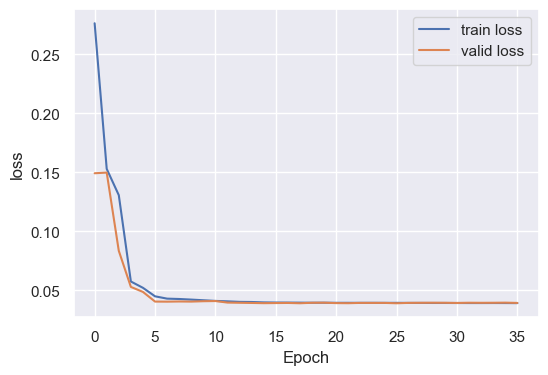

In [20]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

15/15 [==============================] - 0s 670us/step




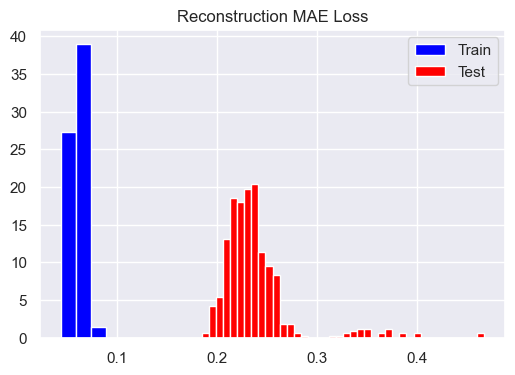



Train (Normal Only) Reconstruction error threshold: 0.19188504936498543


Test Reconstruction error threshold: 0.4666127772001498


In [21]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,x_train,x_test)

Confusion Matrix
[[446   0]
 [  1  27]]


정확도: 0.998 정밀도: 1.0 재현율: 0.964 AUC: 0.993 F1: 0.982 F2: 0.971 Balanced_Accuracy: 0.982


              precision    recall  f1-score   support

          양품       1.00      1.00      1.00       446
          불량       1.00      0.96      0.98        28

    accuracy                           1.00       474
   macro avg       1.00      0.98      0.99       474
weighted avg       1.00      1.00      1.00       474



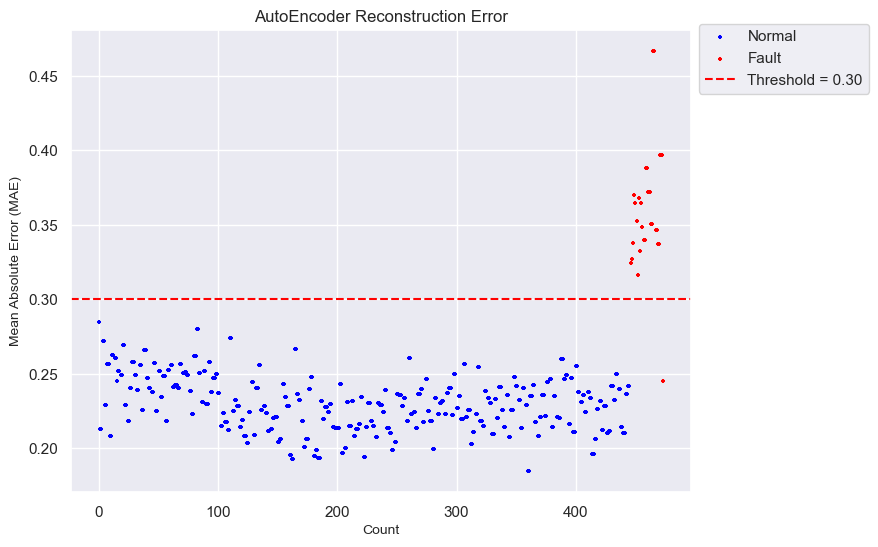

In [22]:
anomaly_threshold(threshold = 0.3, model = autoencoder)

### Unlabeled Data 예측 & 공정 최적화

In [23]:
df_unlabeled = load_unlabeled_df(part_type)

part type: CN7 shape (35239, 46)
unique _ids : 35239


PART_NAME
CN7 W/S SIDE MLD'G LH    19333
CN7 W/S SIDE MLD'G RH    15906
Name: count, dtype: int64


EQUIP_CD
S14    35239
Name: count, dtype: int64


EQUIP_NAME
650톤-우진2호기    35239
Name: count, dtype: int64


In [24]:
inputs = df_unlabeled[X_train.columns]

#### 1.) 부품 세부 선택 [ 필요 시]

In [25]:
#unlabeled = load_unlabeled_df(part_type)

In [26]:
#df_unlabeled = unlabeled_part_name(i)

In [27]:
#inputs = df_unlabeled[X_train.columns]

In [28]:
scaler.fit(inputs)
x_pred = pd.DataFrame(scaler.transform(inputs),columns = inputs.columns)

1102/1102 [==============================] - 1s 707us/step


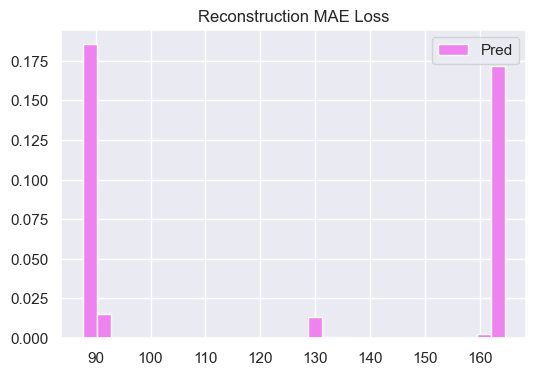



Pred Reconstruction error threshold: 164.68447076017037


In [29]:
pred = autoencoder.predict(x_pred)
pred_mae_loss = np.mean(np.abs(pred - inputs), axis=1)
threshold_pred = np.max(pred_mae_loss) 

plt.figure(figsize=(6,4))
plt.title('Reconstruction MAE Loss')
plt.hist(pred_mae_loss,bins=30,color='violet',density=True,label='Pred')
plt.legend()
plt.show()
threshold_pred = np.max(pred_mae_loss) 
print('\n')
print("Pred Reconstruction error threshold:", threshold_pred)

In [30]:
pred_mae_loss.describe()

count    35239.000000
mean       123.655314
std         36.337174
min         87.614372
25%         88.856918
50%         91.388245
75%        162.938632
max        164.684471
dtype: float64

In [31]:
pred_mae_loss.quantile(0.95)

163.54996140086777

score
0    31715
1     3524
Name: count, dtype: int64


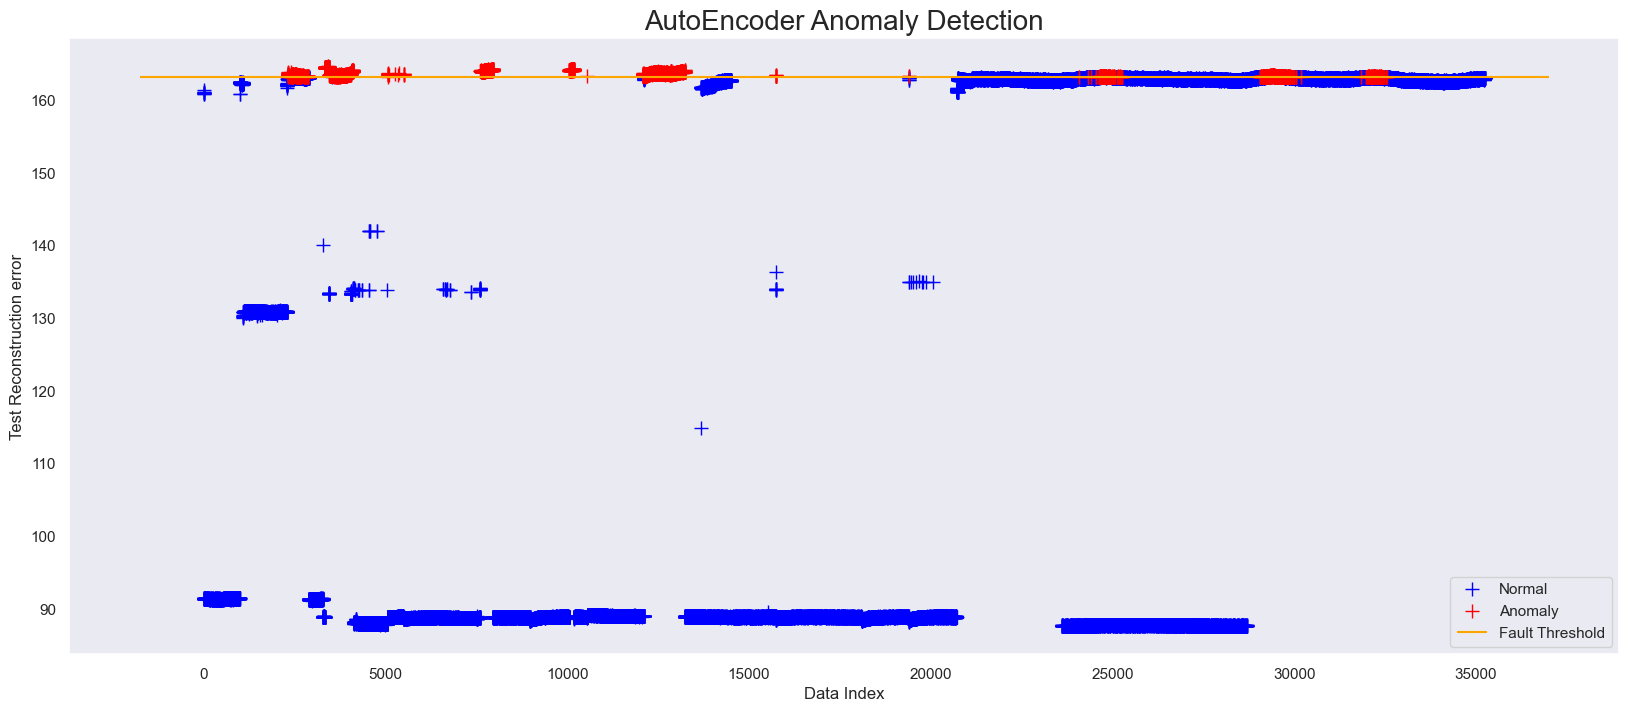

In [32]:
pred_df,pred_good,pred_fault = pred_anomaly_threshold(threshold = pred_mae_loss.quantile(0.9))

#### 2.) 데이터 정리

In [33]:
#### 공정 진단 비교 기준
Trained_Normal = df_normal.select_dtypes(exclude='object').drop(['PassOrFail'],axis=1)

#### 예측 완료 데이터 
pred_rescaled = pd.concat([df_unlabeled,pred_df['score']],axis=1)

pred_normal = pred_rescaled[pred_rescaled['score'] == 0]
pred_fault = pred_rescaled[pred_rescaled['score'] == 1]

Trained_Normal.shape,pred_normal.shape,pred_fault.shape

((3946, 24), (31715, 47), (3524, 47))

#### 3.) 특정 변수 분포 비교

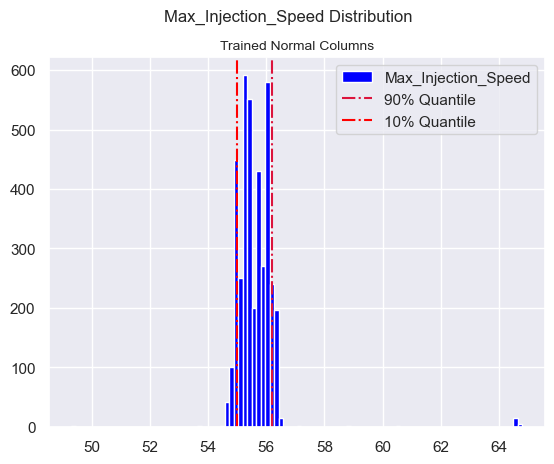

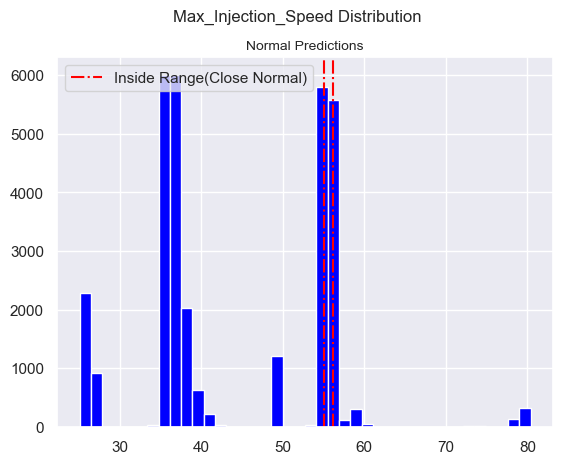

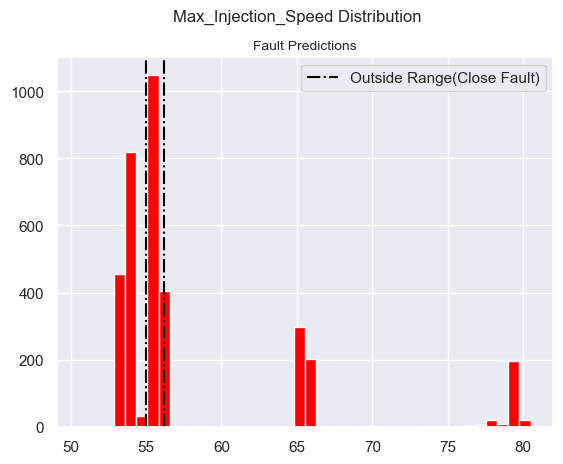

In [34]:
i = 8
zoom = False

#### 학습(정상) & 예측[정상/불량 택1] 분포 비교
select_col = column_distribution(i,zoom)

#### 4.) 특정 ID 대상 전체 변수 진단 

In [35]:
normal_ids = pred_normal['_id'].unique().tolist()
fault_ids = pred_fault['_id'].unique().tolist()

select_cols = Trained_Normal.columns.tolist()
print(select_cols)

['Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position', 'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure', 'Max_Switch_Over_Pressure', 'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3', 'Mold_Temperature_4']


In [36]:
#### 1개의 ID [ 하나의 행]가 가지는 변수들에 대한 공정 진단 

#_id = 2 # ID
#cols = 3  # 동적 변수

In [37]:
#### 전체 

#for cols in range(0,len(select_cols)):
#    manufacture_diagnosis(_id, cols)

#### 5.) 특정 ID대상 주요 변수 진단 & 차트

- 기존 학습 데이터 or 예측 데이터[라벨링 완료] 기준
- 변수선택 모델 선정 & 주요변수 5개 차트

In [38]:
#Train_X = df_final[X_train.columns]
#Train_Y = df_final['PassOrFail']

Train_X = pred_rescaled[X_train.columns] 
Train_Y = pred_rescaled['score'] 

rf = RandomForestClassifier(random_state=2021,class_weight='balanced')
xgb = XGBClassifier(random_state=2021,scale_pos_weight = Train_Y.value_counts()[0]/Train_Y.value_counts()[1])
lgb = LGBMClassifier(scale_pos_weight = Train_Y.value_counts()[0]/Train_Y.value_counts()[1])

#### 모델 리스트 
ml = [rf,xgb,lgb]

#### Logistic Regression 5% 유의변수
sig_vals = lr_significant_values(0.05,mute=True)

         Current function value: 0.009746
         Iterations: 35


In [39]:
print('Feature Importance List')
print('\n')
for i in range(0,len(ml)):
    feature_selection(i)
print('Logistic Regression -->',sig_vals)

Feature Importance List


RandomForest  -->  ['Mold_Temperature_4', 'Mold_Temperature_3', 'Cycle_Time', 'Plasticizing_Position', 'Average_Back_Pressure']
XGBoost  -->  ['Mold_Temperature_4', 'Max_Back_Pressure', 'Cycle_Time', 'Mold_Temperature_3', 'Max_Injection_Speed']
LightGBM  -->  ['Mold_Temperature_4', 'Mold_Temperature_3', 'Barrel_Temperature_1', 'Hopper_Temperature', 'Barrel_Temperature_4']
Logistic Regression --> ['Cycle_Time', 'Clamp_Close_Time', 'Max_Injection_Speed', 'Barrel_Temperature_6', 'Hopper_Temperature']


In [40]:
imp_cols = feature_selection(i=1)

XGBoost  -->  ['Mold_Temperature_4', 'Max_Back_Pressure', 'Cycle_Time', 'Mold_Temperature_3', 'Max_Injection_Speed']


Id -->  5f9141f36e37704af87cd08c
TimeStamp -->  2020-05-27 17:17:39
Part Name -->  CN7 W/S SIDE MLD'G RH
Part NO -- > 86141AA000


Columns: ['Mold_Temperature_4', 'Max_Back_Pressure', 'Cycle_Time', 'Mold_Temperature_3', 'Max_Injection_Speed']
Column Values: [33.1, 26.8, 67.16, 24.2, 79.7]
Median Normal Values: [23.5, 37.900001525878906, 59.52000045776367, 22.100000381469727, 55.5]
Diagnosis Result -->


Mold_Temperature_4  =  33.1


하위 10% 측정값 : 22.100000381469727
중앙 측정값 : 23.5
상위 10% 측정값 : 24.899999618530277


진단 결과
Mold_Temperature_4 하향 조정 대상-->  - 8.200000381469724


추천 의사결정 -->  Mold_Temperature_4 조정




Max_Back_Pressure  =  26.8


하위 10% 측정값 : 37.29999923706055
중앙 측정값 : 37.900001525878906
상위 10% 측정값 : 38.400001525878906


진단 결과
Max_Back_Pressure 상향 조정 대상-->  + 10.499999237060546


추천 의사결정 -->  Max_Back_Pressure 조정




Cycle_Time  =  67.16


하위 10% 측정값 : 59.459999084472656
중앙 측정값 : 59.52000045776367
상위 10% 측정값 : 59.560001373291016


진단 결과
Cycle_Time 하향 조정 대상-->  - 7.59999862670898

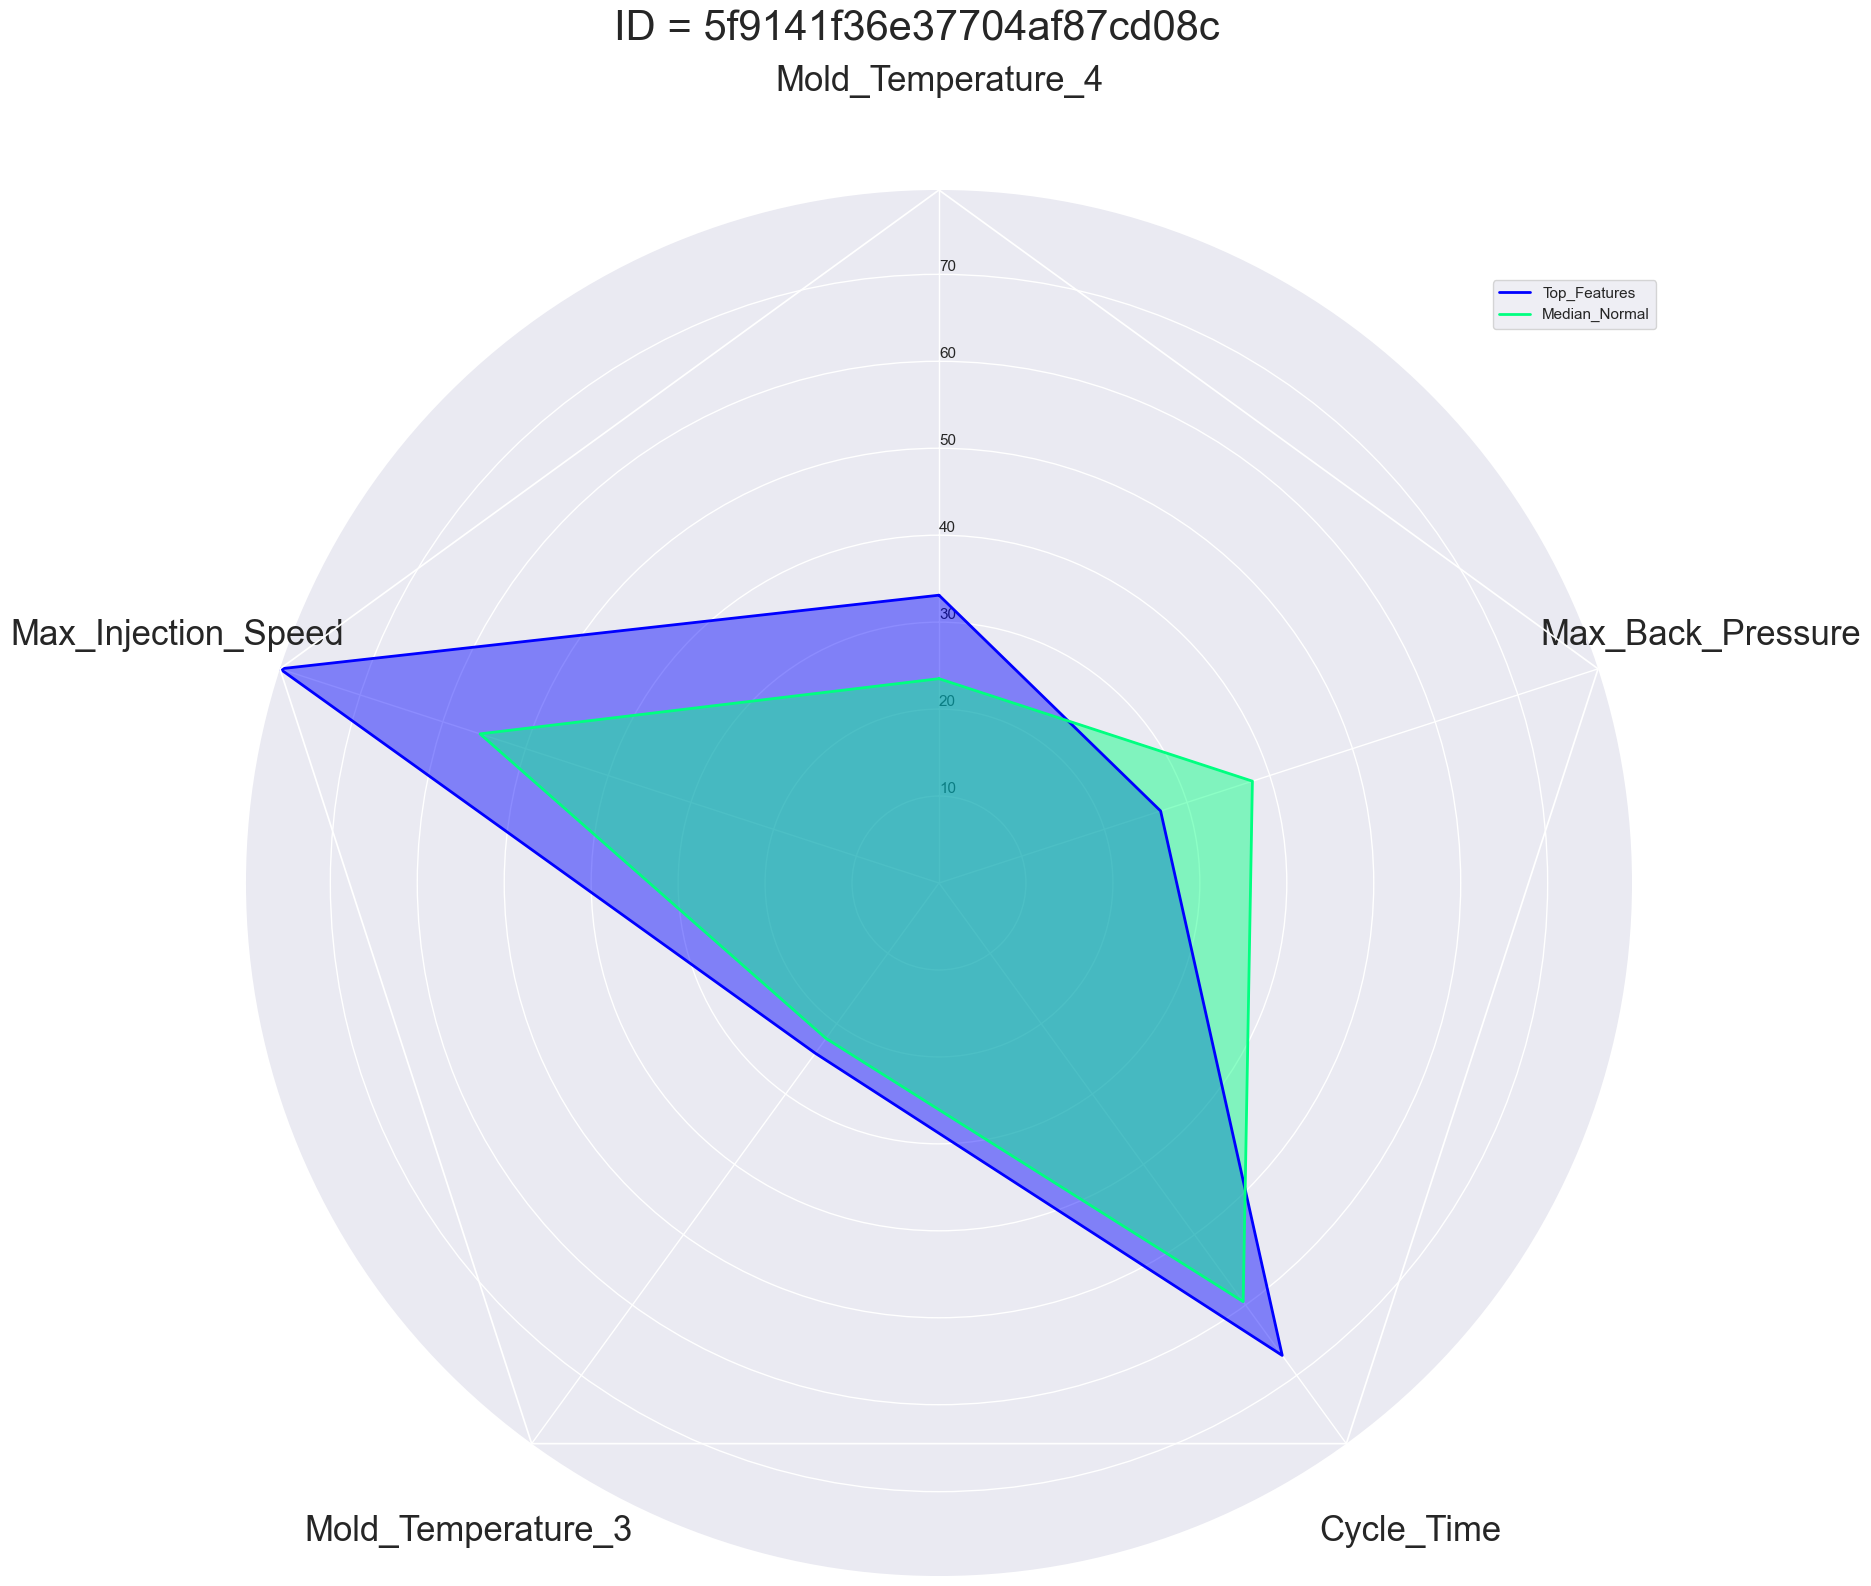

In [41]:
_id = 227
mute = False

comprehensive_fault_diagnosis(_id,mute) 

In [42]:
#for _id in range(0,10):
#    comprehensive_fault_diagnosis(_id,mute) 